# Adversarial Vadiation

In [1]:
from adversarial_validation import *
from path import *

In [2]:
df_train = pl.read_parquet(INTERIM_DATA_DIR / "train.parquet")
df_test  = pl.read_parquet(INTERIM_DATA_DIR / "test.parquet")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
print(f"Ratio of test: {df_test.height / (df_train.height + df_test.height):.2f}")

Train shape: (590540, 434), Test shape: (506691, 433)
Ratio of test: 0.46


## **Data Preparation**

In [3]:
train_shuffled, test_shuffled, df_combined = create_adversarial_data(df_train, df_test, train_ratio=0.8)

## **Experiments**

In [4]:
drop_list = [av_target]
cat_cols = df_train.select(cs.string()).columns
auc_history = []
av = AdversarialValidation(train_shuffled, test_shuffled, model_config)

2025/12/12 00:14:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/12 00:14:02 INFO mlflow.store.db.utils: Updating database tables
2025/12/12 00:14:02 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/12 00:14:02 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/12 00:14:02 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/12 00:14:02 INFO alembic.runtime.migration: Will assume non-transactional DDL.


### Phase 01: Baseline on the raw data.

Adversarial Validation AUC: 1.0000


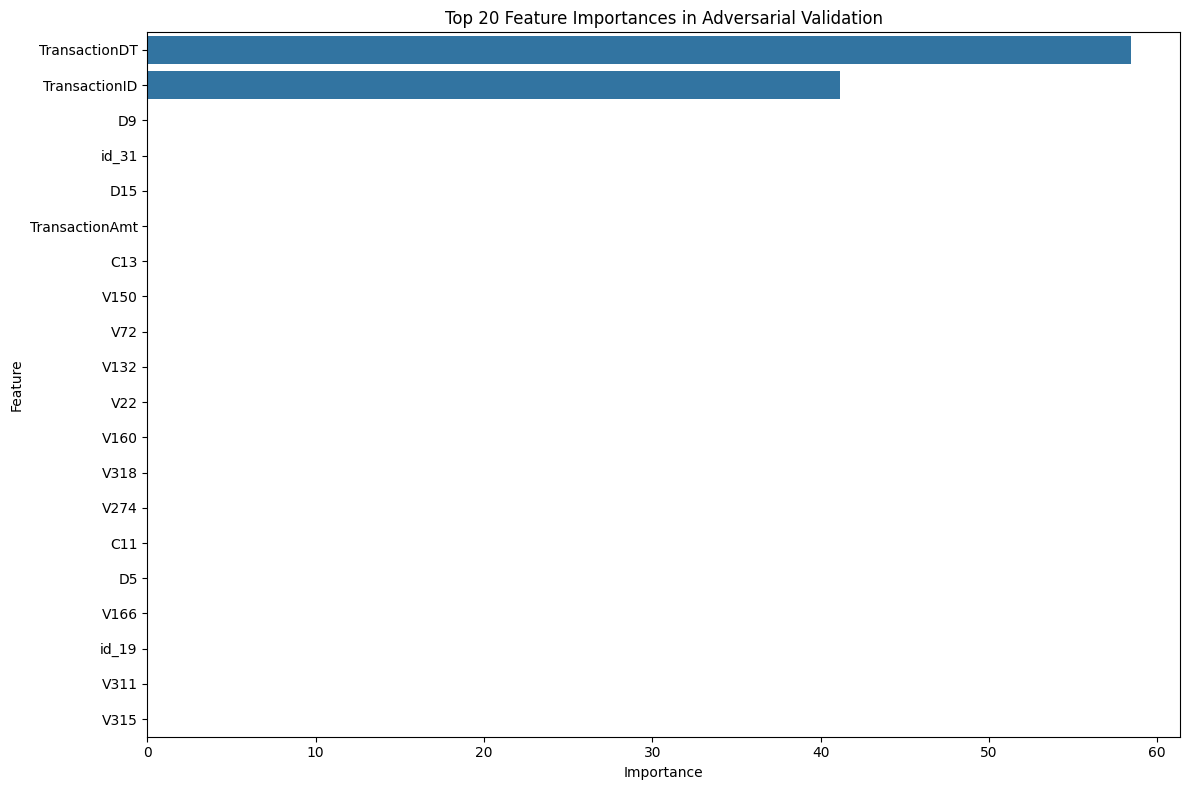

In [5]:
auc, ft_df = av.run(drop_list, cat_cols)
auc_history.append(auc)

TransactionID và TransactionDT phân loại tốt giữa train và test set vì TransactionID là unique ID, và TransactionDT là timestamp (dữ liệu được chia theo yếu tố thời gian)

AUC quá tệ, mô hình sẽ overfit nặng trên tập train.

In [6]:
drop_list_1 = drop_list + ["TransactionDT", "TransactionID"]

In [7]:
considering_features = ft_df.head(5)["Feature"].tolist()
considering_features

['TransactionDT', 'TransactionID', 'D9', 'id_31', 'D15']

In [8]:
plot_importances(df_combined, considering_features)

Feature: TransactionDT, len(group_0_list): 573349, len(group_1_list): 494686, len(unique_to_0): 494686

Feature: TransactionDT
Target 0 len(573349): [86400, 86401, 86469, 86499, 86506, 86510, 86522, 86529, 86535, 86536, 86549, 86555, 86564, 86585, 86596, 86618, 86620, 86668, 86725, 86730, 86761, 86769, 86786, 86808, 86821, 86944, 86945, 86972, 86973, 86979, 86994, 86998, 87008, 87078, 87135, 87140, 87149, 87161, 87172, 87202, 87209, 87220, 87233, 87248, 87266, 87275, 87285, 87317, 87319, 87328]
Target 1 len(494686): [18403224, 18403263, 18403310, 18403317, 18403323, 18403350, 18403387, 18403405, 18403416, 18403474, 18403504, 18403508, 18403543, 18403553, 18403582, 18403598, 18403632, 18403678, 18403686, 18403735, 18403755, 18403788, 18403829, 18403844, 18403848, 18403854, 18403857, 18403863, 18403881, 18403883, 18403928, 18403929, 18403997, 18404006, 18404011, 18404013, 18404024, 18404055, 18404064, 18404065, 18404087, 18404109, 18404128, 18404157, 18404212, 18404231, 18404235, 1840425

__Feature: id_31__

Thực chất `id_31` là một thông tin đến từ trường "user-agent" đến từ HTTP Request đã được làm sạch. 

Feature này đặc biệt ở chỗ:

- Có trường version đi kèm với tên: train ("chrome 62.0"), và test ("chrome 67.0").

- Có tính phân loại theo "nguồn sử dụng": "chrome xx for **android**", "chrome xx for **ios**"

__Feature: d_15__

feature có prefix `d` là timedelta nên dễ hiểu vì sao nó quan trọng. Hiện tai chưa hiểu data nên chưa có giải pháp hạn chế tác động của nó.

### Phase 02: Generalize the `id_31` feature

In [9]:
plot_importances(df_combined, ["id_31"])

Feature: id_31, len(group_0_list):   131, len(group_1_list):   136, len(unique_to_0): 42

Feature: id_31
Target 0 len(131): ['<UNK>', 'samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', 'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic', 'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic', 'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0', 'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome', 'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android', 'mobile safari 10.0', 'chrome 61.0 for android', 'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0', 'chrome generic', 'other', 'chrome 59.0 for android', 'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0', 'ie', 'chrome 55.0 for android', 'firefox 52.0', 'chrome 57.0 for android', 'chrome 56.0', 'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0', 'chrome 59.0', 'samsung browser 4.0', 'edge 13.0', 'chrome 53.0 for android', 'chrome 58.0 for android', 'chrome 

In [10]:
def generalize_id31(df: pl.DataFrame, column: str) -> pl.DataFrame:
    return df.with_columns(
        pl.col(column)
        .str.to_lowercase()
        .str.replace(r"\s\d+(\.\d+)+", "")
        # .str.replace(r"(.*) generic", "${1}")
        .str.replace(r"samsung(.*)", "samsung")
    )

In [11]:
tmp_df_combined = generalize_id31(df_combined, "id_31")
plot_importances(tmp_df_combined, ["id_31"])

Feature: id_31, len(group_0_list):    53, len(group_1_list):    25, len(unique_to_0): 3

Feature: id_31
Target 0 len(53): ['<unk>', 'samsung', 'mobile safari', 'chrome', 'chrome for android', 'edge', 'mobile safari generic', 'safari generic', 'firefox', 'mobile safari uiwebview', 'chrome for ios', 'ie for desktop', 'ie for tablet', 'chrome generic', 'other', 'android webview', 'opera', 'ie', 'firefox generic', 'generic/android', 'mobile', 'chrome generic for android', 'aol', 'silk', 'waterfox', 'nokia/lumia', 'puffin', 'microsoft/windows', 'cyberfox', 'opera generic', 'zte/blade', 'safari', 'android browser', 'palemoon', 'maxthon', 'line', 'lg/k-200', 'iron', 'blu/dash', 'seamonkey', 'm4tel/m4', 'comodo', 'lanix/ilium', 'chromium', 'inco/minion', 'mozilla/firefox', 'cherry', 'icedragon', 'android', 'google']
Target 1 len(25): ['<unk>', 'chrome for android', 'ie for tablet', 'mobile safari', 'chrome', 'ie for desktop', 'edge', 'firefox', 'samsung', 'safari', 'chrome for ios', 'google se

In [12]:
transform = DataTransformer()
transform.add_transform(Transform("generalize_id31", "id_31", "Generalizes a column by removing version numbers", generalize_id31))

Adversarial Validation AUC: 0.8223


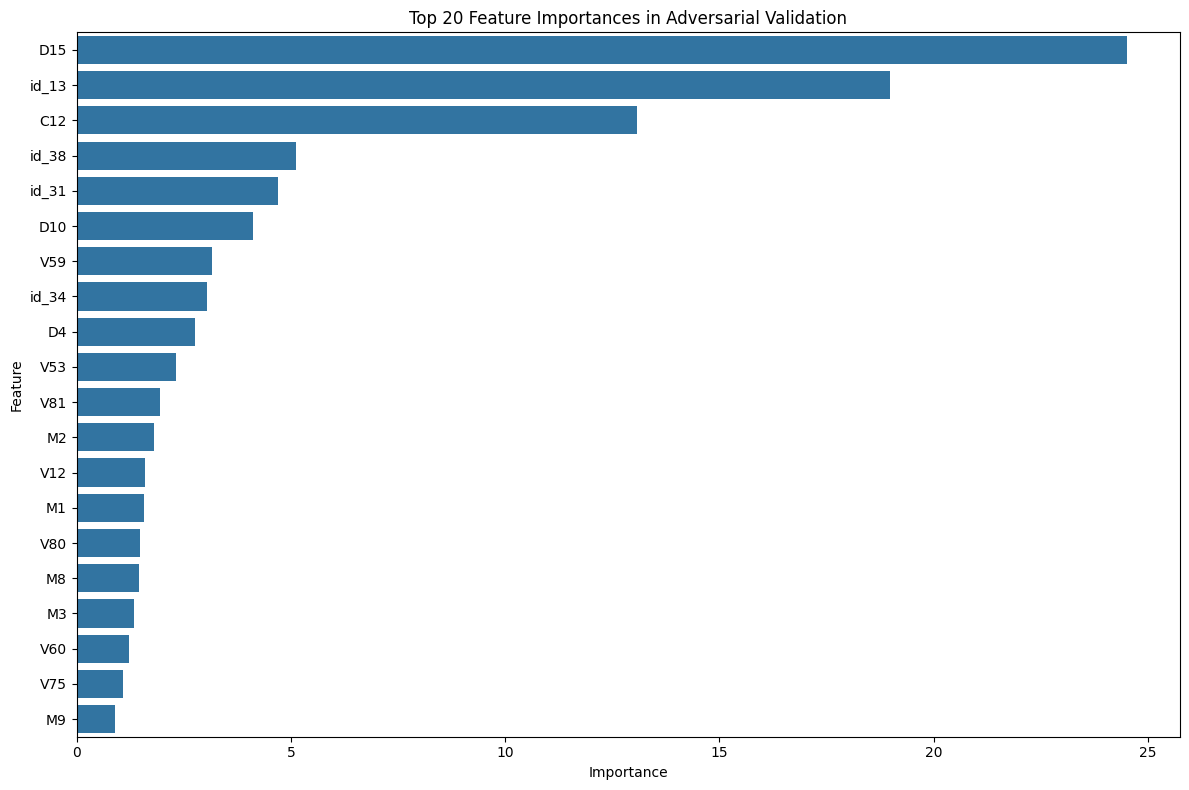

In [13]:
auc, ft_df = av.run(drop_list=drop_list_1, cat_features=cat_cols, transform=transform)
auc_history.append(auc)

In [14]:
considering_features = ft_df.head(20)["Feature"].tolist()
considering_features

['D15',
 'id_13',
 'C12',
 'id_38',
 'id_31',
 'D10',
 'V59',
 'id_34',
 'D4',
 'V53',
 'V81',
 'M2',
 'V12',
 'M1',
 'V80',
 'M8',
 'M3',
 'V60',
 'V75',
 'M9']

In [15]:
df_combined = transform.transform(df_combined)
plot_importances(df_combined, considering_features)

Feature:   D15, len(group_0_list):   860, len(group_1_list):  1079, len(unique_to_0): 232

Feature: D15
Target 0 len(860): [0.0, 315.0, 111.0, None, 318.0, 107.0, 45.0, 62.0, 109.0, 65.0, 26.0, 244.0, 391.0, 259.0, 121.0, 245.0, 290.0, 477.0, 541.0, 389.0, 22.0, 289.0, 2.0, 406.0, 458.0, 20.0, 5.0, 35.0, 12.0, 104.0, 248.0, 237.0, 466.0, 284.0, 46.0, 455.0, 456.0, 218.0, 77.0, 450.0, 403.0, 444.0, 71.0, 9.0, 39.0, 428.0, 327.0, 40.0, 249.0, 143.0]
Target 1 len(1079): [409.0, 634.0, 97.0, 242.0, 22.0, 0.0, 126.0, 673.0, 43.0, 237.0, 170.0, 133.0, 597.0, 582.0, 690.0, 247.0, 364.0, 108.0, 119.0, 5.0, 180.0, 236.0, 113.0, 116.0, 694.0, 7.0, 15.0, 405.0, 572.0, 138.0, 12.0, 661.0, 87.0, 282.0, 693.0, 9.0, 25.0, 594.0, 149.0, 346.0, 419.0, 1.0, 382.0, None, 686.0, 178.0, 388.0, 666.0, 90.0, 668.0]
Features that only test have (len=232) [1024.0, 1025.0, 1026.0, 1027.0, 1028.0, 1029.0, 1030.0, 1031.0, 1032.0, 1033.0, 1034.0, 1035.0, 1036.0, 1037.0, 1038.0, 1039.0, 1040.0, 1042.0, 1043.0, 1044

In [16]:
plot_importances(df_combined, ["id_30"])

Feature: id_30, len(group_0_list):    76, len(group_1_list):    87, len(unique_to_0): 12

Feature: id_30
Target 0 len(76): ['<UNK>', 'Android 7.0', 'iOS 11.1.2', 'Mac OS X 10_11_6', 'Windows 10', 'Android', 'Linux', 'iOS 11.0.3', 'Mac OS X 10_7_5', 'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'iOS 11.1.0', 'Mac OS X 10_9_5', 'Windows 7', 'Windows 8.1', 'Mac', 'iOS 10.3.3', 'Mac OS X 10.12', 'Mac OS X 10_10_5', 'Mac OS X 10_11_5', 'iOS 9.3.5', 'Android 5.1.1', 'Android 7.1.1', 'Android 6.0', 'iOS 10.3.1', 'Mac OS X 10.9', 'iOS 11.1.1', 'Windows Vista', 'iOS 10.3.2', 'iOS 11.0.2', 'Mac OS X 10.11', 'Android 8.0.0', 'iOS 10.2.0', 'iOS 10.2.1', 'iOS 11.0.0', 'Mac OS X 10.10', 'Mac OS X 10_12_3', 'Mac OS X 10_12', 'Android 6.0.1', 'iOS', 'Mac OS X 10.13', 'Mac OS X 10_12_5', 'Mac OS X 10_8_5', 'iOS 11.0.1', 'iOS 10.0.2', 'Android 5.0.2', 'Windows XP', 'iOS 11.2.0', 'Mac OS X 10.6', 'Windows 8']
Target 1 len(87): ['<UNK>', 'Android 6.0.1', 'iOS 11.4.0', 'Windows 7', 'iOS 10.1.1', 'Windows 10', 'M

In [17]:
def generalize_id30(df: pl.DataFrame, column: str) -> pl.DataFrame:
    return df.with_columns(
        pl.col(column)
        .str.to_lowercase()
        .str.replace(r"android 9", "android")
        .str.replace_all(r"_", ".")
        .str.replace(r"(\d+).(\d+).(\d+)", r"${1}")
    )

In [18]:
tmp_df_combined = generalize_id30(df_combined, "id_30")
plot_importances(tmp_df_combined, ["id_30"])

Feature: id_30, len(group_0_list):    32, len(group_1_list):    34, len(unique_to_0): 2

Feature: id_30
Target 0 len(32): ['<unk>', 'android 7.0', 'ios 11', 'mac os x 10', 'windows 10', 'android', 'linux', 'windows 7', 'windows 8.1', 'mac', 'ios 10', 'mac os x 10.12', 'ios 9', 'android 5', 'android 7', 'android 6.0', 'mac os x 10.9', 'windows vista', 'mac os x 10.11', 'android 8', 'mac os x 10.10', 'android 6', 'ios', 'mac os x 10.13', 'windows xp', 'mac os x 10.6', 'windows 8', 'android 4', 'android 5.0', 'func', 'other', 'windows']
Target 1 len(34): ['<unk>', 'android 6', 'ios 11', 'windows 7', 'ios 10', 'windows 10', 'mac os x 10', 'linux', 'android 5', 'ios 9', 'android 7.0', 'mac os x 10.13', 'android 8', 'windows 8.1', 'android', 'mac', 'windows 8', 'android 7', 'windows vista', 'windows xp', 'mac os x 10.11', 'ios 12', 'android 6.0', 'ios', 'mac os x 10.12', 'mac os x 10.14', 'func', 'mac os x 10.10', 'android 5.0', 'mac os x 10.6', 'mac os x 10.9', 'windows', 'android 4', 'othe

In [19]:
transform.add_transform(Transform("generalize_id30", "id_30", "Generalizes id_30 values into broader categories", generalize_id30))

Adversarial Validation AUC: 0.8223


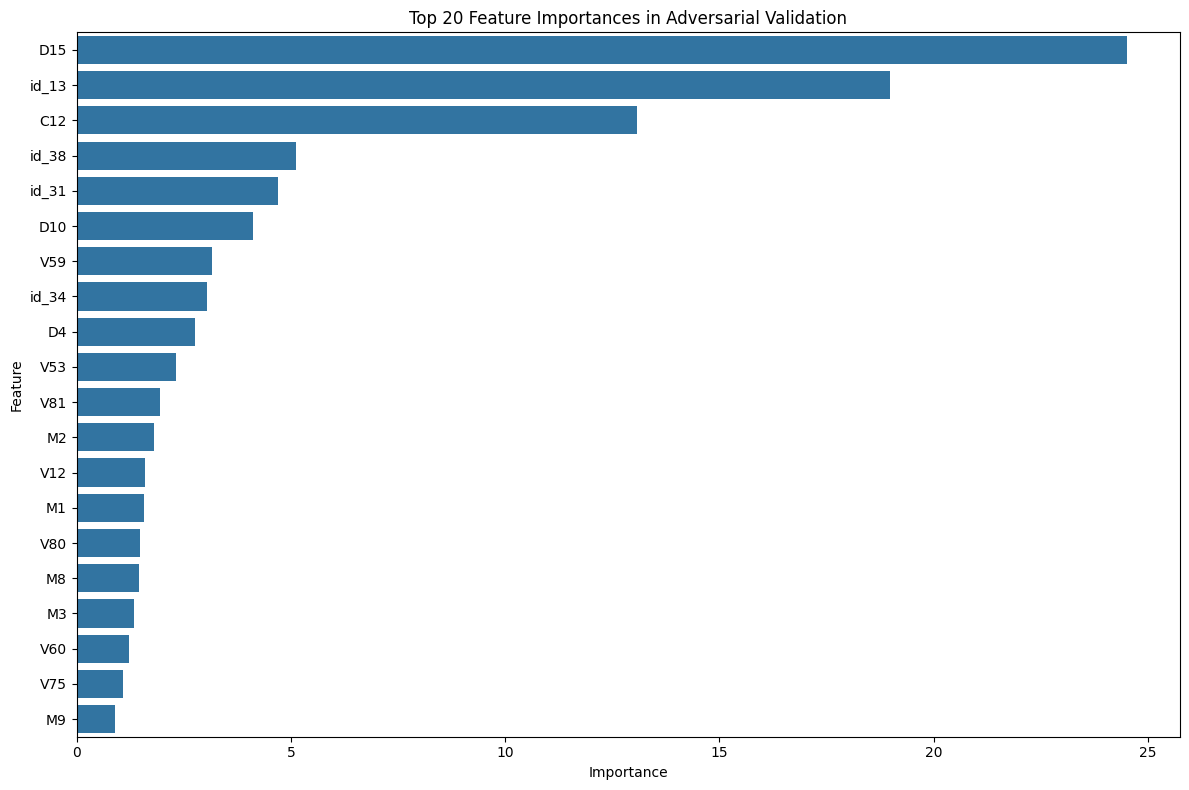

In [20]:
auc, ft_df = av.run(drop_list=drop_list_1, cat_features=cat_cols, transform=transform)
auc_history.append(auc)

In [21]:
print(transform)

DataTransformer(transforms=['Transform(name=generalize_id31, column=id_31, info=Generalizes a column by removing version numbers)', 'Transform(name=generalize_id30, column=id_30, info=Generalizes id_30 values into broader categories)'])
